# Plot Flowines Using Remote Greenland Ice Mapping Project Data
---

This notebook demonstrates how Greenland Ice Mapping Project can be remotely accessed to create plots along flowlines from [Felikson et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112), which are archived on [Zenodo](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112). The copies of the shapefiles included in this repository were downloaded in late January 2022. The notebook works with a specific set of glacier ids but is easily modified to plot results for other glaciers in the flowline data set.

## Environment Setup

The following packages are needed to execute this notebook. The notebook has been tested with the `environment.yml` in the *binder* folder of this repository. Thus, for best results, create a new conda environment to run this and other other GrIMP notebooks from this repository. 

`conda env create -f binder/environment.yml`

`conda activate greenlandMapping`

`python -m ipykernel install --user --name=greenlandMapping`

`jupyter lab`

See [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for additional information.

The notebooks can be run on a temporary virtial instance (to start click [**binder**](https://mybinder.org/v2/gh/fastice/GrIMPNotebooks/HEAD?urlpath=lab)). See the github [README](https://github.com/fastice/GrIMPNotebooks#readme) for further details.

## Python Setup

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
import matplotlib.colors as mcolors
import grimpfunc as grimp
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import xarray as xr
import importlib
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
import glob
import panel
panel.extension()

**Note to get help and see options for any of the GrIMP or other functions while the cursor is positioned inside a method's parentheses, click shift+Tab.**

## Read Shapefiles

In the examples presented here we will use glaciers 1 through 6 in the Felikson data base, which should have downloaded as part of the notebook repository. Glacier 6 has two variants, so some extra work is needed to extract. Each glacier's flowlines are used to great `grimp.Flowlines` instances, which are saved in a dictionary, `myFlowlines` with glacier id: '0001' through 'b006'. To limit the plots to the downstream regions, the flowlines are all truncated to a `length` of 50km. Within each myFlowines entry (a `grimp.Flowlines` instance), the individual flowlines are maintained as a dictionary `myFlowlines['glacierId'].flowlines`. The line with `glob`, which effectively is an `ls` command can be modified to select other glaciers. Minor tweaks may be needed to optimize the plots generated below to accomodate the different geometries.

In [2]:
myShapeFiles = []
for i in range(1, 7):
    myShapeFiles += glob.glob(f'./shpfiles/glacier?00{i}.shp')  # Search for glaciers with ?00n where n ranges from 1 to 6
# Build dictionary with flowlines indexed by glacier id
myFlowlines = {x[-8:-4]: grimp.Flowlines(shapefile=x, name=x[-8:-4], length=50e3) for x in myShapeFiles} 
myFlowlines

{'0001': <grimpfunc.Flowlines.Flowlines at 0x32a45c620>,
 '0002': <grimpfunc.Flowlines.Flowlines at 0x1072a4110>,
 '0003': <grimpfunc.Flowlines.Flowlines at 0x32b8b09e0>,
 '0004': <grimpfunc.Flowlines.Flowlines at 0x32b8b0c20>,
 '0005': <grimpfunc.Flowlines.Flowlines at 0x32b8b0fb0>,
 'b006': <grimpfunc.Flowlines.Flowlines at 0x32b8b1100>,
 'a006': <grimpfunc.Flowlines.Flowlines at 0x32b8b16d0>}

The last cell created a dictionary of flowline objects, indexed by glacier id (e.g., '0001'...). Each object contains a dictionary with several flowlines for that glacier indexed by flowline index:

In [3]:
myFlowlines['0001'].flowlines.keys()

dict_keys(['03', '04', '05', '06', '07', '08'])

The information for each flowline contains a dictionary the x, y coordinates and distance along the flowline, d:

In [4]:
myFlowlines['0001'].flowlines['03'].keys()

dict_keys(['x', 'y', 'd'])

The area of interest can be defined as the union of the bounds for all of the flowlines computed as shown below along with the unique set of flowline IDs across all glaciers.

In [5]:
myBounds = {'minx': 1e9, 'miny': 1e9, 'maxx': -1e9, 'maxy': -1e9}  # Initial bounds to force reset
flowlineIDs = []  # 
for myKey in myFlowlines:
    myBounds = myFlowlines[myKey].mergeBounds(myBounds, myFlowlines[myKey].bounds)
    flowlineIDs.append(myFlowlines[myKey].flowlineIDs())
flowlineIDs = np.unique(flowlineIDs)
print(myBounds)
print(flowlineIDs)

{'minx': np.float64(-220000.0), 'miny': np.float64(-2314100.0), 'maxx': np.float64(-127800.0), 'maxy': np.float64(-2132100.0)}
['03' '04' '05' '06' '07' '08']


## Search Catalog for Velocity Data

For remote access to data at NSIDC, run these cells to login with your NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details). These cells can skipped if all data are being accessed locally. First define where the cookie files need for login are saved.

In [6]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)

Now enter credentials. If previous valid cookie exists, login credentials can be skipped.

In [7]:
myLogin = grimp.NASALogin()
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


The next cell searches the NSIDC database for the desired full Sentinel-1 based GRiMP velocity mosaics. For purposes of demonstration, it comes up with a search result for annual mosaics. Use the controls to search for data ranging from 6-day to annual resolution. Note download times scale with temporal resolution. 

In [8]:
# For some environments the tool is unresponsive (i.e., search button doesn't work) - this can often be fixed by re-running this cell
myUrls = grimp.cmrUrls(mode='nisar')  # nisar mode excludes image and tsx products and allows only one product type at a time
myUrls.initialSearch()

Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame, defer_load=False)
        [1] ParamMethod(method, _pane=Markdown, defer_load=False)
        [2] ParamMethod(method, _pane=Markdown, defer_load=False)

## To Chunk or Not

There are two ways to read the data, which are controlled by the parameter `useStack`:
1) `useStack=True` (default): In this case, each band of the subsetted data is loaded as a single file read operation (e.g., no chunks in xy). For most cases, this is the faster option because there is no dask overhead and the single reads tend to be faster. This is the preferred option for anything that involves reading in data with `loadRemote` and doing repeated operations on the result. **Note: with this option, the keyword `chunks` will be ignored.**
2) `useStack=False`: In this case, the data are chunked with rio-xarray and dask, which can add 10s of seconds or more overhead to set up the xarray, which slows the lazy reads. There are only a few use cases in which this mode would be preferred. For example, examining only a few points in a large subset **without** using `loadRemote`, so that as the data are input on the fly, only the chunks surrounding the points would be read. In most cases, it's best to minimize the subset area (e.g., for one glacier) or use multiple subsets for widely spaced glaciers.

In [9]:
useStack=True

## Number of Workers

With Dask you can use `numWorkers` to specify multiple parallel threads, which can speed up downloads. It can also cause the download to fail (with something that looks like a file not found error) if the server decides it's receiving too many concurrent requests. The criteria under which this happens are unclear, and whether it has to do with the number of connections, open files, etc. This means the results could differ for the type of data product/access. For example, downloading a large number of TSX files (many file open operations per unit time) might cause things to break before the case where large pieces are pulled from full ice sheet mosaics (files are held open for long periods). Beyond `numWorkers=8`, the point of diminishing returns is approached. In general, `numWorkers=4` will be fairly robust, and provide good performance. But you can experiment by setting `numWorkers` below. Note: this discussion is most applicable to network reads. For local file systems, the speedup may be substantially less due to file contention.

In [10]:
numWorkers = 4

## Load the Velocity Data

While the velocity data are stored as multiple files at NSIDC, they can all be combined into a single `nisarVelSeries` instance. This instance will set all the data structures up, but will not initially download the data.

In [11]:
myVelSeries = nisar.nisarVelSeries(numWorkers=numWorkers) # Create Series
urlNames = [x.replace('vv','*').replace('.tif','') for x in myUrls.getCogs()] # Add wild card and remove trailing tiff
myVelSeries.readSeriesFromTiff(urlNames, url=True, readSpeed=False, useStack=useStack)  
myVelSeries.xr  # Add semicolon after to suppress output

<xarray.DataArray 'VelocityMap' (time: 9, band: 3, y: 13700, x: 7585)> Size: 11GB
dask.array<getitem, shape=(9, 3, 13700, 7585), dtype=float32, chunksize=(1, 1, 13700, 7585), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 61kB -6.59e+05 -6.588e+05 ... 8.576e+05 8.578e+05
  * y            (y) float64 110kB -6.392e+05 -6.394e+05 ... -3.379e+06
  * time         (time) datetime64[ns] 72B 2015-06-01 ... 2023-06-01
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B 'None'
    _FillValue   (band) float64 24B -2e+09 -2e+09 -1.0
    spatial_ref  int64 8B 0
    time1        (time) datetime64[ns] 72B 2014-12-01 2015-12-01 ... 2022-12-01
    time2        (time) datetime64[ns] 72B 2015-11-30 2016-11-30 ... 2023-11-30

For the annual data set, this step produces a ~7GB data sets, which expands to 370GB for the full data set. To avoid downloading unnessary data, the data can be subsetted using the bounding box from the flowlines. 

In [12]:
myVelSeries.subsetVel(myBounds) # Apply subset
myVelSeries.subset # Add semicolon after to suppress output

<xarray.DataArray 'VelocityMap' (time: 9, band: 3, y: 910, x: 462)> Size: 45MB
dask.array<getitem, shape=(9, 3, 910, 462), dtype=float32, chunksize=(1, 1, 910, 462), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 4kB -2.2e+05 -2.198e+05 ... -1.28e+05 -1.278e+05
  * y            (y) float64 7kB -2.132e+06 -2.132e+06 ... -2.314e+06 -2.314e+06
  * time         (time) datetime64[ns] 72B 2015-06-01 ... 2023-06-01
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B 'None'
    _FillValue   (band) float64 24B -2e+09 -2e+09 -1.0
    spatial_ref  int64 8B 0
    time1        (time) datetime64[ns] 72B 2014-12-01 2015-12-01 ... 2022-12-01
    time2        (time) datetime64[ns] 72B 2015-11-30 2016-11-30 ... 2023-11-30

The volume of the data set is now a far more manageable ~29MB, which is still located in the archive.  Operations can continue without downloading, but if lots of operations are going to occur, it is best to download the data upfront. 

In [13]:
myVelSeries.loadRemote() # Load the data to memory

[########################################] | 100% Completed | 9.17 ss


## Display Flowlines and Velocity

The flowlines over one of the velocity layers can be displayed as with the following block of code. In addition to plotting the flowline, a point 10 km along each flowline is plotted and saved for subsequent plots below.

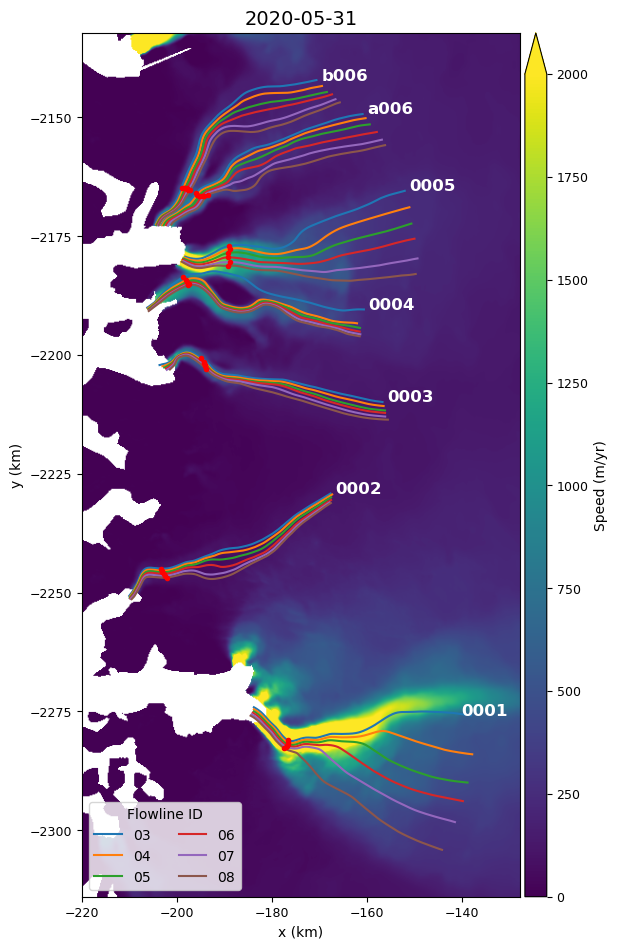

In [14]:
# set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6,12))
glacierPoints = {}
# generate a color dict that spans all flowline ids, using method from a flowline instance
flowlineColors = list(myFlowlines.values())[0].genColorDict(flowlineIDs=flowlineIDs)
# Messy plot stuff to get glacier labels in right place
xShift = {x: 1 for x in myFlowlines} # Dict index by glacier id
xShift['0001'] = -2 # custom for jakobshavn to keep on plot
# Display the velocity map for 2020 (note picks map nearest the date given). 
# Saturate color table at 2000 to maintain slower detail (vmax=2000)
myVelSeries.displayVelForDate('2020-01-01', ax=ax, labelFontSize=10, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=2000, units='km') 
# Look over each glacier and plot the flowlines
for glacierId in myFlowlines:
    # Plot the flowline Match units to the map
    myFlowlines[glacierId].plotFlowlineLocations(ax=ax, units='km', colorDict=flowlineColors)
    # 
    myFlowlines[glacierId].plotGlacierName(ax=ax, units='km', xShift=xShift[glacierId], 
                                           color='w', fontsize=12,fontweight='bold', first=False)
    # Generates points 10km
    points10km = myFlowlines[glacierId].extractPoints(10, None, units='km')
    glacierPoints[glacierId] = points10km
    for key in points10km:
        ax.plot(*points10km[key], 'r.')
# Create a dict of unique labels for legend
h, l = ax.get_legend_handles_labels()
by_label = dict(zip(l, h))
# Add legend
ax.legend(by_label.values(), by_label.keys(), title='Flowline ID', ncol=2)

## Plot Central Flowlines at Different Times

This example will demonstrate plotting the nominally central flowline ('06') for each of the six years for which there are currently data. This example works for annual data. Minor modifications are needed for the legend if more frequent data are selected above. 

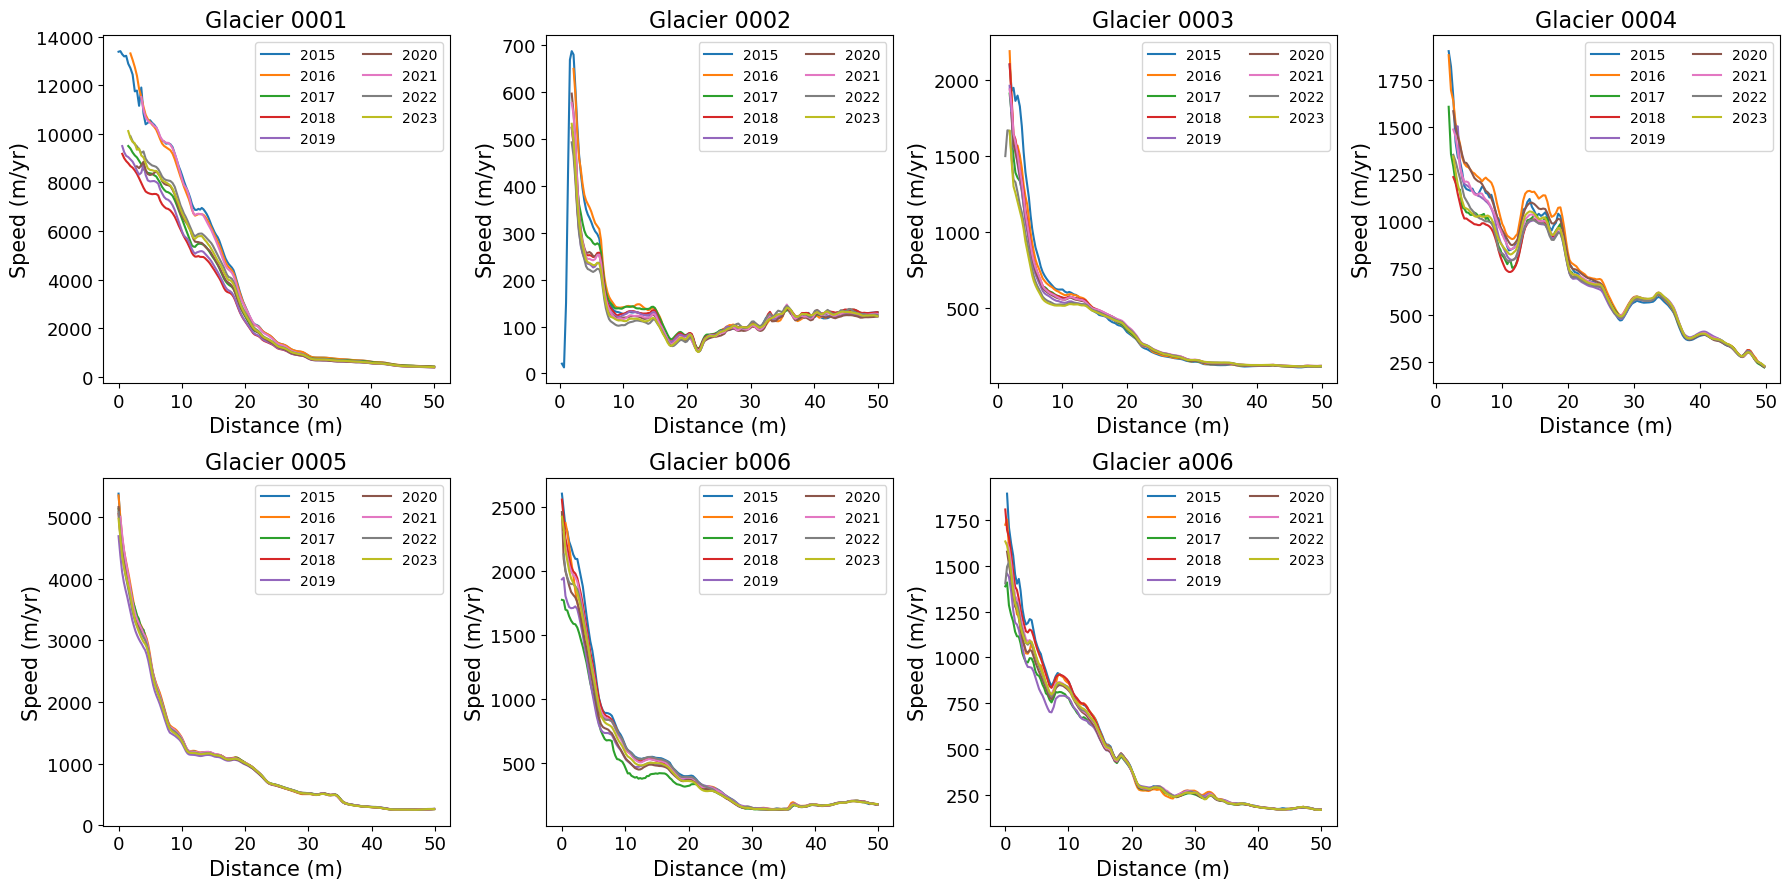

In [15]:
flowlineId ='06'  # Flowline id to plot
fig, axes = plt.subplots(np.ceil(len(myFlowlines)/4).astype(int), 4, figsize=(18, 9))  # Setup plot
# Loop over glaciers
for glacierId, ax in zip(myFlowlines, axes.flatten()):
    # return interpolated values as vx(time index, distance index)
    # vx, vy, vv = myVelSeries.interp(*myFlowlines[glacierId].xy(units='km'), units='km') 
    # loop over each profile by time
    for myDate in myVelSeries.time:
        # new plot method
        myVelSeries.plotProfile(*myFlowlines[glacierId].xy(index=flowlineId, units='km'), date=myDate, label=myDate.year, units='km', ax=ax)
        # ax.plot(myFlowlines[glacierId].flowlineDistance(units='km'), speed, label=myDate.year)
    # pretty up plot
    ax.legend(ncol=2, loc='upper right')
    #ax.set_xlabel('Distance (km)', fontsize=13)
    #ax.set_ylabel('Speed (m/yr)', fontsize=13,)
    myVelSeries.labelProfilePlot(ax, title=f'Glacier {glacierId}')
    #ax.set_title(f'Glacier {glacierId}')
for ax in axes.flatten()[len(myFlowlines):]:
    ax.axis('off'); # kill axis with no plot
plt.tight_layout()

## Plot Points Through Time

This example plots the points extracted from 10 km along the flowine as a time series for each glacier.

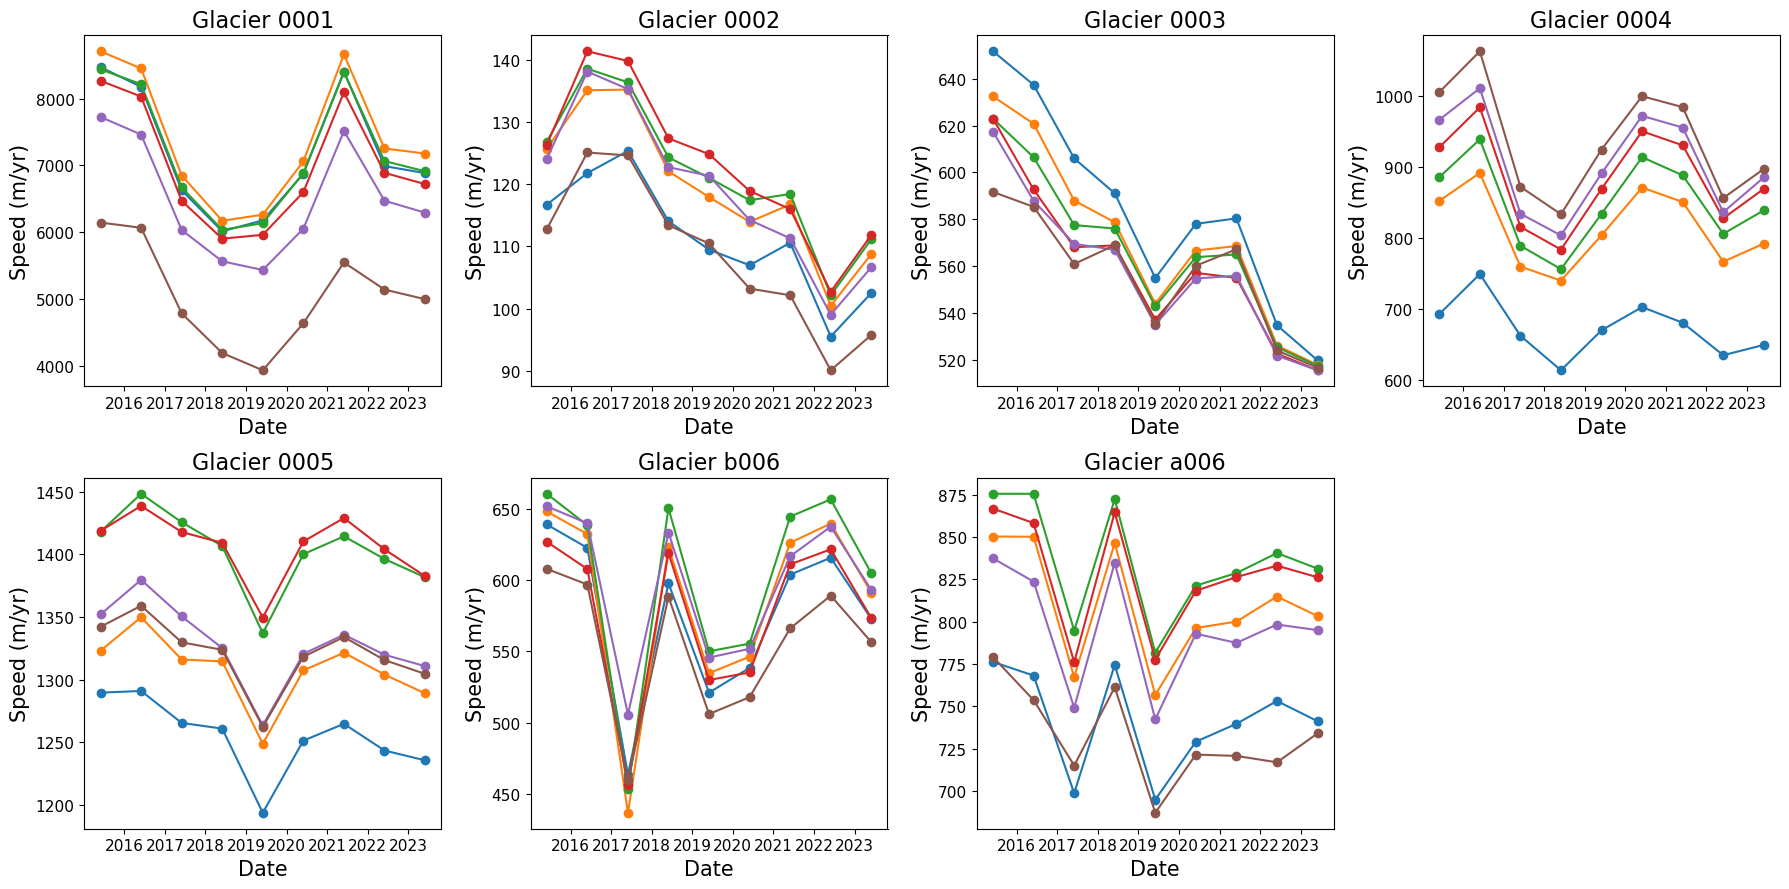

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# Loop over glaciers
for glacierId, ax in zip(glacierPoints, axes.flatten()):
    # Loop over flowlines
    for flowlineId in glacierPoints[glacierId]:
        # 
        # Old: interpolate to get results vx(time index) for each point
        #vx, vy, v = myVelSeries.interp(*glacierPoints[glacierId][flowlineId], units='km')
        #ax.plot(myVelSeries.time, v, marker='o',  linestyle='-', color=flowlineColors[flowlineId],label=f'{flowlineId}')
        # New method
        myVelSeries.plotPoint(*glacierPoints[glacierId][flowlineId], ax=ax, band='vv',  marker='o',  linestyle='-',
                              color=flowlineColors[flowlineId],label=f'{flowlineId}',units='km')
    # pretty up plot
    myVelSeries.labelPointPlot(ax, title=f'Glacier {glacierId}', plotFontSize=11)
    #ax.tick_params(axis='both', labelsize=11)
    #ax.legend(ncol=3, loc='upper right', title='Flowline ID')
    #ax.set_xlabel('year', fontsize=13)
    #ax.set_ylabel('Speed (m/yr)', fontsize=13)
    #ax.set_title(f'Glacier {glacierId}')
    
axes[-1, -1].axis('off'); # kill axis with no plot
plt.tight_layout()

## Save the Data

The downloaded subset can be saved in a netcdf and reloaded for to `velSeries` instance for later analysis. Note if the data have been subsetted, the subset will be saved (~30MB in this example). If not, the entire Greeland data set will be saved (370GB). Change `saveData` and `reloadData` below to test this capability.

In [17]:
saveData = True # Set to True to save data
if saveData:
    myVelSeries.toNetCDF('Glaciers1-6example.nc')

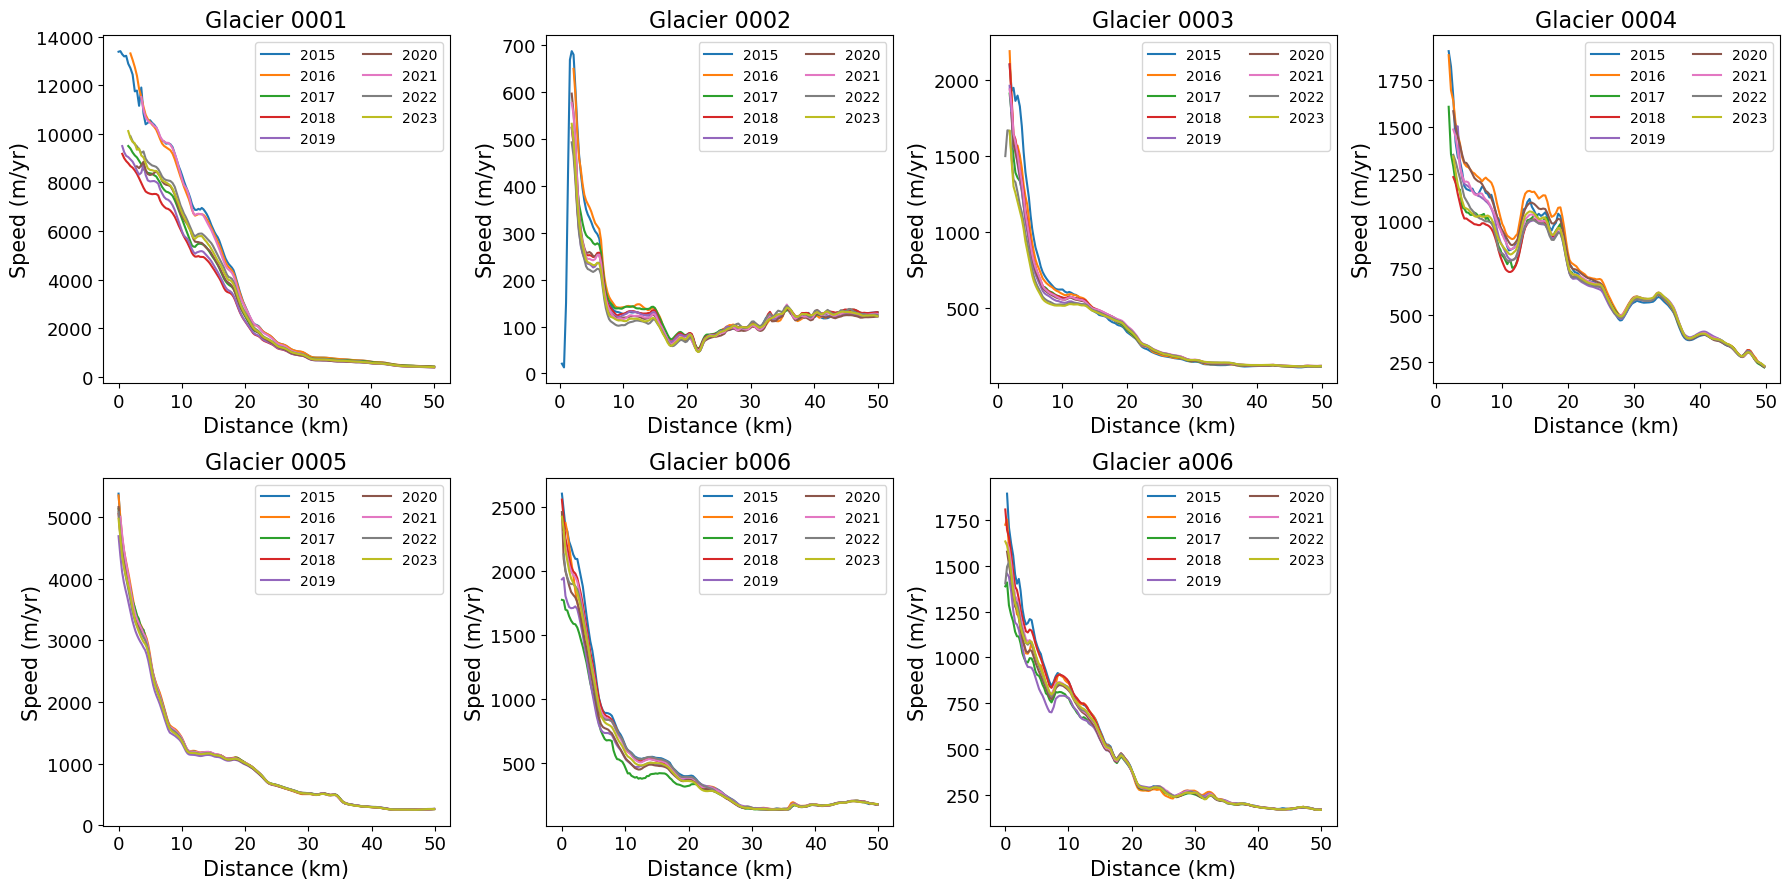

In [18]:
reloadData = True  # Set to True to reload the saved data
if reloadData:
    myVelCDF = nisar.nisarVelSeries() # Create Series
    myVelCDF.readSeriesFromNetCDF('Glaciers1-6example.nc')
    #
    # repeat the above example with reloaded data
    flowlineId ='06'  # Flowline id to plot
    fig, axes = plt.subplots(np.ceil(len(myFlowlines)/4).astype(int), 4, figsize=(18, 9))  # Setup plot
    # Loop over glaciers
    for glacierId, ax in zip(myFlowlines, axes.flatten()):
        # loop over each profile by time
        for myDate in myVelCDF.time:
            myVelSeries.plotProfile(*myFlowlines[glacierId].xy(index=flowlineId, units='km'), date=myDate, label=myDate.year, units='km', ax=ax)
        # pretty up plot
        myVelSeries.labelProfilePlot(ax, title=f'Glacier {glacierId}', units='km')
        ax.legend(ncol=2, loc='upper right')
    for ax in axes.flatten()[len(myFlowlines):]:
        ax.axis('off'); # kill axis with no plot
    plt.tight_layout()